In [1]:
#Test #5:

# Sequence Modelling Question.
#
# For this task you will need to train a neural network
# to predict sunspot activity using the Sunspots.csv
# provided. Your neural network is expected to have an MAE
# of at least 20, with top marks going to one with an MAE
# of around 15. At the bottom is provided some testing
# code should you want to check before uploading which measures
# the MAE for you. Strongly recommend you test your model with
# this to be able to see how it performs.
 
import csv
import tensorflow as tf
import numpy as np
import urllib
 
# DO NOT CHANGE THIS CODE
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1) 


In [13]:
import matplotlib.pyplot as plt

# def plot_series(time, series, format="-", start=0, end=None):
#     plt.plot(time[start:end], series[start:end], format)
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     plt.grid(True)

def solution_model():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
    urllib.request.urlretrieve(url, 'sunspots.csv')
 
    # Your data should be loaded into 2 Python lists called time_step
    # and sunspots. They are decleared here.
    time_step = []
    sunspots = []
 
    with open('sunspots.csv') as csvfile:
        # YOUR CODE HERE
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
          sunspots.append(float(row[2]))
          time_step.append(int(row[0]))
    # You should use numpy to create 
    # - your series from the list of sunspots
    # - your time details from the list of time steps
    series = np.array(sunspots)
    time = np.array(time_step)
 
    # You should split the dataset into training and validation splits
    # At time 3000. So everything up to 3000 is training, and everything
    # after 3000 is validation. Write the code below to achieve that.
    split_time = 3000
    time_train = time[:split_time]
    x_train = series[:split_time]
    time_valid = time[split_time:]
    x_valid = series[split_time:]
 
    # DO NOT CHANGE THIS CODE
    window_size = 30
    batch_size = 32
    shuffle_buffer_size = 1000
 
    model = tf.keras.models.Sequential([
      # DO NOT CHANGE THE FINAL TWO LAYERS FROM BELOW
      tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])
    # window_size = 64
    # batch_size = 256
    train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
    optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    history = model.fit(train_set, epochs=100)
 
    return model, series,time_valid,x_valid, window_size

In [14]:
model, series,time_valid,x_valid, window_size= solution_model()

Epoch 1/100
93/93 [==============================] - 1s 8ms/step - loss: 30.5464 - mae: 31.0418
Epoch 2/100
93/93 [==============================] - 1s 8ms/step - loss: 22.4427 - mae: 22.9368
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 21.8090 - mae: 22.3025
Epoch 4/100
93/93 [==============================] - 1s 8ms/step - loss: 20.7140 - mae: 21.2075
Epoch 5/100
93/93 [==============================] - 1s 8ms/step - loss: 20.0262 - mae: 20.5195
Epoch 6/100
93/93 [==============================] - 1s 8ms/step - loss: 19.0535 - mae: 19.5462
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 19.1556 - mae: 19.6483
Epoch 8/100
93/93 [==============================] - 1s 8ms/step - loss: 19.2072 - mae: 19.6998
Epoch 9/100
93/93 [==============================] - 1s 8ms/step - loss: 19.1352 - mae: 19.6279
Epoch 10/100
93/93 [==============================] - 1s 8ms/step - loss: 18.3606 - mae: 18.8526
Epoch 11/100
93/93 [===================

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
split_time = 3000
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

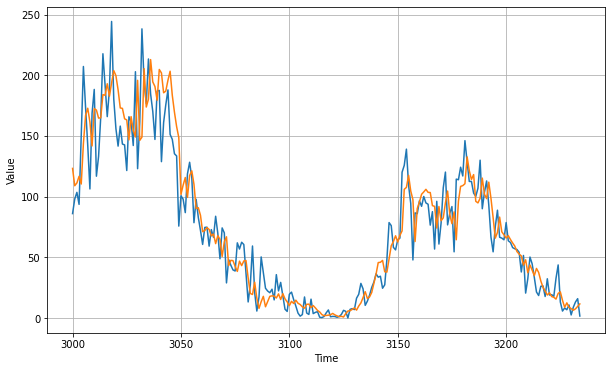

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)